# Traffic and Airprox Correlations
> Author: A.Pilko@soton.ac.uk

2019 Air traffic data and 2000-2021 airprox data is used to investigate correlations in the datasets.

## Hypotheses:
- Airprox locations will have less ordered traffic flow, concretely the variance of traffic direction will positively correlate with airprox locations
- Airprox locations will positively correlate with traffic density
- Airprox locations will positively correlate with mean traffic flow speed
- Airprox locations will positively correlate with the variance of the flow speed


Import required libraries and pre-cleaned data

In [2]:
import geopandas as gpd
import pandas as pd
import seaborn as sns
import traffic
import numpy as np
import pyproj
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import joblib as jl

from cartopy.crs import Projection
from traffic.drawing import countries, lakes, ocean
from traffic.data import airports

%matplotlib notebook

In [3]:
airprox_gdf = gpd.GeoDataFrame(pd.read_pickle('../data/airprox_asp_2000_2021.pkl'))
# tfc_clean = traffic.core.Traffic.from_file('../data/cornwall/cornwall_tfc_clean_30s_lt3000ft_2019_f16.pkl.bz2')
tfc_clean = traffic.core.Traffic.from_file('../data/southeng/southeng_tfc_clean_lt5000ft_2019.pkl.bz2')

In [4]:
# tfc_clean_data = pd.read_pickle('../data/cornwall/cornwall_tfc_clean_30s_lt3000ft_2019_f16.pkl.bz2')

In [5]:
tfc_clean.data.describe()

,altitude,geoaltitude,groundspeed,latitude,longitude,track,vertical_rate,track_unwrapped
count,17932899.0,17970520.0,18014373.0,1.804224e+07,1.804224e+07,17970729.00,17996370.0,1.797073e+07
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,0.000000e+00,0.000000e+00,NaN,NaN,NaN
min,-1600.0,-3550.0,0.0,5.050000e+01,-2.900391e+00,0.00,-32640.0,-inf
25%,1025.0,1025.0,127.0,5.118750e+01,-5.708008e-01,90.00,-768.0,8.575000e+01
50%,2124.0,2150.0,151.0,5.146875e+01,-3.012695e-01,253.25,-512.0,2.533750e+02
75%,3700.0,3576.0,189.0,5.153125e+01,-1.937866e-02,269.50,64.0,2.700000e+02
max,inf,5000.0,4088.0,5.190625e+01,1.500000e+00,360.00,32640.0,9.728000e+03


## Airspace

There isn't much point analysing the traffic patterns for controlled airspace where ATC are issuing instructions or aircraft are (usually) following standard routes (SIDs, STARs). The UK airspace is used to filter out the traffic state vectors that are located in controlled airspace. All the traffic that is only in uncontrolled airspace is then used for the actual analysis.

In [6]:
import requests

req = requests.get('https://storage.googleapis.com/29f98e10-a489-4c82-ae5e-489dbcd4912f/gb_asp.geojson')
with open('gb_asp.geojson', 'w') as f:
    f.write(req.text)

In [7]:
ASP_TYPES = {
    0: "Other",
    1: "Restricted",
    2: "Danger",
    3: "Prohibited",
    4: "Controlled Tower Region (CTR)",
    5: "Transponder Mandatory Zone (TMZ)",
    6: "Radio Mandatory Zone (RMZ)",
    7: "Terminal Maneuvering Area (TMA)",
    8: "Temporary Reserved Area (TRA)",
    9: "Temporary Segregated Area (TSA)",
    10: "Flight Information Region (FIR)",
    11: "Upper Flight Information Region (UIR)",
    12: "Air Defense Identification Zone (ADIZ)",
    13: "Airport Traffic Zone (ATZ)",
    14: "Military Airport Traffic Zone (MATZ)",
    15: "Airway",
    16: "Military Training Route (MTR)",
    17: "Alert Area",
    18: "Warning Area",
    19: "Protected Area",
    20: "Helicopter Traffic Zone (HTZ)",
    21: "Gliding Sector",
    22: "Transponder Setting (TRP)",
    23: "Traffic Information Zone (TIZ)",
    24: "Traffic Information Area (TIA)",
    25: "Military Training Area (MTA)",
    26: "Controlled Area (CTA)",
    27: "ACC Sector (ACC)",
    28: "Aerial Sporting Or Recreational Activity",
    29: "Low Altitude Overflight Restriction"
}

ASP_CLASS = {
    0: "A",
    1: "B",
    2: "C",
    3: "D",
    4: "E",
    5: "F",
    6: "G",
    7: "Special Use Airspace (SUA)",
    8: "Unclassified"
}

ASP_ACTIVITIES = {
    0: "None - No specific activity (default)",
    1: "Parachuting Activity",
    2: "Aerobatics Activity",
    3: "Aeroclub And Arial Work Area",
    4: "Ultra Light Machine (ULM) Activity",
    5: "Hang Gliding/Paragliding"
}

ASP_ALT_UNIT = {
    0: "Meter",
    1: "Feet",
    6: "Flight Level",
}

ASP_ALT_DATUM = {
    0: "GND",
    1: "MSL",
    2: "STD",
}

In [8]:

asp_gdf = gpd.read_file('gb_asp.geojson')
asp_gdf = asp_gdf[(asp_gdf['approved'] == True) & (asp_gdf['onDemand'] == False) & (asp_gdf['onRequest'] == False) & (
        asp_gdf['byNotam'] == False) & (asp_gdf['specialAgreement'] == False)]
asp_gdf = asp_gdf.cx[
          tfc_clean.data.longitude.min():tfc_clean.data.longitude.max(),
          tfc_clean.data.latitude.min(): tfc_clean.data.latitude.max()
          ].reset_index()
asp_upper_lims = pd.DataFrame(pd.json_normalize(asp_gdf.upperLimit))
asp_lower_lims = pd.DataFrame(pd.json_normalize(asp_gdf.lowerLimit))
asp_upper_lims.columns = ['upperLimit_value', 'upperLimit_unit', 'upperLimit_ref']
asp_lower_lims.columns = ['lowerLimit_value', 'lowerLimit_unit', 'lowerLimit_ref']
asp_lim_df = pd.concat([asp_lower_lims, asp_upper_lims], axis=1)
pd.concat([asp_gdf, asp_lim_df], axis=1)

# asp_gdf

,index,_id,approved,name,type,icaoClass,activity,onDemand,onRequest,byNotam,...,updatedAt,createdBy,updatedBy,geometry,lowerLimit_value,lowerLimit_unit,lowerLimit_ref,upperLimit_value,upperLimit_unit,upperLimit_ref
0,7,62cacfd10ba090870156145d,True,BERRY HEAD CTA,0,0,0,False,False,False,...,2022-07-10 13:10:41.462000+00:00,OPONcQnzWGOLiJSceNaf8pvx1fA2,OPONcQnzWGOLiJSceNaf8pvx1fA2,"POLYGON ((-2.89306 51.25139, -2.99333 50.70444...",105,6,2,195,6,2
1,35,62cacfd40ba0908701561577,True,BRISTOL CTA 125.650,0,3,0,False,False,False,...,2022-07-10 13:10:44.651000+00:00,OPONcQnzWGOLiJSceNaf8pvx1fA2,OPONcQnzWGOLiJSceNaf8pvx1fA2,"POLYGON ((-2.52833 51.47333, -2.52833 51.47333...",1500,1,1,105,6,2
2,36,62cacfd40ba0908701561581,True,BRISTOL CTA 125.650,0,3,0,False,False,False,...,2022-07-10 13:10:44.775000+00:00,OPONcQnzWGOLiJSceNaf8pvx1fA2,OPONcQnzWGOLiJSceNaf8pvx1fA2,"POLYGON ((-2.95883 51.37879, -2.95878 51.38819...",1500,1,1,105,6,2
3,37,62cacfd40ba090870156158b,True,BRISTOL CTA 125.650,0,3,0,False,False,False,...,2022-07-10 13:10:44.893000+00:00,OPONcQnzWGOLiJSceNaf8pvx1fA2,OPONcQnzWGOLiJSceNaf8pvx1fA2,"POLYGON ((-2.43722 51.47667, -2.43722 51.47667...",2000,1,1,105,6,2
4,39,62cacfd50ba090870156159f,True,BRISTOL CTA 125.650,0,3,0,False,False,False,...,2022-07-10 13:10:45.108000+00:00,OPONcQnzWGOLiJSceNaf8pvx1fA2,OPONcQnzWGOLiJSceNaf8pvx1fA2,"POLYGON ((-2.51250 51.30722, -2.51250 51.30722...",3000,1,1,105,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,955,62cad0450ba09087015639ac,True,WHITE WALTHAM ATZ 122.605,13,7,0,False,False,False,...,2022-07-10 13:12:37.465000+00:00,OPONcQnzWGOLiJSceNaf8pvx1fA2,OPONcQnzWGOLiJSceNaf8pvx1fA2,"POLYGON ((-0.77472 51.53387, -0.77808 51.53380...",0,1,0,2127,1,1
276,959,62cad0450ba09087015639d5,True,WYCOMBE ATZ 126.555,13,7,0,False,False,False,...,2022-07-10 13:12:37.941000+00:00,OPONcQnzWGOLiJSceNaf8pvx1fA2,OPONcQnzWGOLiJSceNaf8pvx1fA2,"POLYGON ((-0.80833 51.64498, -0.81170 51.64491...",0,1,0,2520,1,1
277,960,62cad0460ba09087015639e1,True,YEOVIL ATZ 130.805,13,7,0,False,False,False,...,2022-07-10 13:12:38.072000+00:00,OPONcQnzWGOLiJSceNaf8pvx1fA2,OPONcQnzWGOLiJSceNaf8pvx1fA2,"POLYGON ((-2.62972 50.96778, -2.62972 50.96778...",0,1,0,2200,1,1
278,961,62cad0460ba09087015639e9,True,YEOVIL ILS,0,6,0,False,False,False,...,2022-07-10 13:12:38.170000+00:00,OPONcQnzWGOLiJSceNaf8pvx1fA2,OPONcQnzWGOLiJSceNaf8pvx1fA2,"POLYGON ((-2.71167 50.93944, -2.86972 50.93750...",0,1,0,2200,1,1


In [9]:
asp_gdf = gpd.read_file('gb_asp.geojson')
asp_gdf = asp_gdf[(asp_gdf['approved'] == True) & (asp_gdf['onDemand'] == False) & (asp_gdf['onRequest'] == False) & (
        asp_gdf['byNotam'] == False) & (asp_gdf['specialAgreement'] == False)]
asp_gdf = asp_gdf.cx[
          tfc_clean.data.longitude.min():tfc_clean.data.longitude.max(),
          tfc_clean.data.latitude.min(): tfc_clean.data.latitude.max()
          ].reset_index()
asp_upper_lims = pd.DataFrame(pd.json_normalize(asp_gdf.upperLimit))
asp_lower_lims = pd.DataFrame(pd.json_normalize(asp_gdf.lowerLimit))
asp_upper_lims.columns = ['upperLimit_value', 'upperLimit_unit', 'upperLimit_ref']
asp_lower_lims.columns = ['lowerLimit_value', 'lowerLimit_unit', 'lowerLimit_ref']
asp_lim_df = pd.concat([asp_lower_lims, asp_upper_lims], axis=1)
asp_gdf = pd.concat([asp_gdf, asp_lim_df], axis=1)
asp_gdf = asp_gdf.drop(
    labels=['_id', 'approved', 'specialAgreement', 'onDemand', 'onRequest', 'byNotam', 'createdAt', 'createdBy',
            'updatedAt', 'updatedBy', 'upperLimit', 'lowerLimit'], axis=1)
for col in ['type', 'icaoClass', 'activity']:
    asp_gdf[col] = pd.Categorical(asp_gdf[col])
asp_gdf['type'] = asp_gdf['type'].cat.rename_categories(ASP_TYPES)
asp_gdf['icaoClass'] = asp_gdf['icaoClass'].cat.rename_categories(ASP_CLASS)
asp_gdf['activity'] = asp_gdf['activity'].cat.rename_categories(ASP_ACTIVITIES)

In [10]:
def alt_std(row):
    cr = row.copy()
    if cr['upperLimit_unit'] == 0:
        cr['upperLimit_value'] *= 3.28084
    elif cr['upperLimit_unit'] == 6:
        cr['upperLimit_value'] *= 100

    if cr['lowerLimit_unit'] == 0:
        cr['lowerLimit_value'] *= 3.28084
    elif cr['lowerLimit_unit'] == 6:
        cr['lowerLimit_value'] *= 100

    return cr


# asp_gdf = asp_gdf.apply(alt_std, axis=1).dropna()
asp_gdf = asp_gdf[asp_gdf['lowerLimit_value'] <= 5000]
asp_gdf = asp_gdf.drop(labels=['upperLimit_unit', 'upperLimit_ref', 'lowerLimit_unit', 'lowerLimit_ref'], axis=1)

asp_gdf

,index,name,type,icaoClass,activity,country,geometry,lowerLimit_value,upperLimit_value
0,7,BERRY HEAD CTA,Other,A,None - No specific activity (default),GB,"POLYGON ((-2.89306 51.25139, -2.99333 50.70444...",105,195
1,35,BRISTOL CTA 125.650,Other,D,None - No specific activity (default),GB,"POLYGON ((-2.52833 51.47333, -2.52833 51.47333...",1500,105
2,36,BRISTOL CTA 125.650,Other,D,None - No specific activity (default),GB,"POLYGON ((-2.95883 51.37879, -2.95878 51.38819...",1500,105
3,37,BRISTOL CTA 125.650,Other,D,None - No specific activity (default),GB,"POLYGON ((-2.43722 51.47667, -2.43722 51.47667...",2000,105
4,39,BRISTOL CTA 125.650,Other,D,None - No specific activity (default),GB,"POLYGON ((-2.51250 51.30722, -2.51250 51.30722...",3000,105
...,...,...,...,...,...,...,...,...,...
275,955,WHITE WALTHAM ATZ 122.605,Airport Traffic Zone (ATZ),Special Use Airspace (SUA),None - No specific activity (default),GB,"POLYGON ((-0.77472 51.53387, -0.77808 51.53380...",0,2127
276,959,WYCOMBE ATZ 126.555,Airport Traffic Zone (ATZ),Special Use Airspace (SUA),None - No specific activity (default),GB,"POLYGON ((-0.80833 51.64498, -0.81170 51.64491...",0,2520
277,960,YEOVIL ATZ 130.805,Airport Traffic Zone (ATZ),Special Use Airspace (SUA),None - No specific activity (default),GB,"POLYGON ((-2.62972 50.96778, -2.62972 50.96778...",0,2200
278,961,YEOVIL ILS,Other,G,None - No specific activity (default),GB,"POLYGON ((-2.71167 50.93944, -2.86972 50.93750...",0,2200


In [11]:
tfc_gdf = gpd.GeoDataFrame(tfc_clean.data,
                           geometry=gpd.points_from_xy(tfc_clean.data['longitude'], tfc_clean.data['latitude'],
                                                       tfc_clean.data['altitude']), crs='epsg:4326')

Exception ignored in: <function BaseGeometry.__del__ at 0x7f6970df1900>
Traceback (most recent call last):
  File "/home/aliaksei/anaconda3/envs/sandbox/lib/python3.10/site-packages/shapely/geometry/base.py", line 209, in __del__
    self._empty(val=None)
  File "/home/aliaksei/anaconda3/envs/sandbox/lib/python3.10/site-packages/shapely/geometry/base.py", line 200, in _empty
    self.__geom__ = val
  File "/home/aliaksei/anaconda3/envs/sandbox/lib/python3.10/site-packages/shapely/geometry/base.py", line 250, in __setattr__
    super().__setattr__(name, value)
KeyboardInterrupt: 


KeyboardInterrupt: 

Since shapely only supports 2D geometries, we need to get creative to filter based on 3D airspace volumes. We iterate airspaces and select all traffic that is between the floor and ceiling of that airspace. A 2D point-in-polygon test is then run as usual.

This takes a decent chunk of time...

In [1]:
def tfc_within(lim_asp):
    lim_tfc = tfc_gdf[
        (tfc_gdf['altitude'] >= lim_asp['lowerLimit_value']) & (tfc_gdf['altitude'] <= lim_asp['upperLimit_value'])]
    return lim_tfc.sjoin(gpd.GeoDataFrame(lim_asp.to_frame().T).set_crs(asp_gdf.crs), predicate='within')


joined_dfs = jl.Parallel(n_jobs=-1, verbose=10)(jl.delayed(tfc_within)(lim_asp) for _, lim_asp in asp_gdf.iterrows())

con_asp_tfc_gdf = pd.concat(joined_dfs, axis=0)

NameError: name 'jl' is not defined

In [ ]:
# con_asp_tfc_gdf.to_pickle('../data/cornwall_con_asp_tfc_2019.pkl.bz2', compression='bz2')
# print(con_asp_tfc_gdf.shape)
# con_asp_tfc_gdf.head()

In [ ]:
unc_asp_tfc_gdf = pd.merge(tfc_gdf, con_asp_tfc_gdf, how="outer", indicator=True
                           ).query('_merge=="left_only"').drop(labels=['_merge'], axis=1)
unc_asp_tfc_gdf

In [4]:
# unc_asp_tfc_gdf.to_pickle('../data/cornwall_unc_asp_tfc_2019.pkl.bz2', compression='bz2')
unc_asp_tfc_gdf = pd.read_pickle('../data/southeng/southeng_unc_asp_tfc_2019.pkl.bz2', compression='bz2')

In [10]:
unc_asp_tfc_gdf['type'] = 0
unc_asp_tfc_gdf['icaoClass'] = 6
unc_asp_tfc_gdf['name'] = 'UNCONTROLLED AIRSPACE'
unc_asp_tfc_gdf = unc_asp_tfc_gdf.dropna()

# unc_asp_tfc_gdf = unc_asp_tfc_gdf.drop(
#     labels=['index_right', 'country', 'lowerLimit_value', 'upperLimit_value', 'activity'], axis=1)

In [11]:
unc_asp_tfc_gdf.describe()

,altitude,geoaltitude,groundspeed,latitude,longitude,track,vertical_rate,track_unwrapped,type,icaoClass
count,16355402.0,16355402.0,16355402.0,1.635540e+07,1.635540e+07,16355402.00,16355402.0,1.635540e+07,16355402.0,16355402.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,6.0
std,NaN,NaN,NaN,0.000000e+00,0.000000e+00,NaN,NaN,NaN,0.0,0.0
min,-1600.0,-3550.0,0.0,5.050000e+01,-2.900391e+00,0.00,-32640.0,-inf,0.0,6.0
25%,1025.0,1000.0,128.0,5.118750e+01,-5.185547e-01,90.00,-768.0,8.731250e+01,0.0,6.0
50%,2150.0,2150.0,152.0,5.146875e+01,-2.893066e-01,254.25,-512.0,2.542500e+02,0.0,6.0
75%,3750.0,3600.0,189.0,5.153125e+01,-1.840210e-02,269.75,128.0,2.700000e+02,0.0,6.0
max,inf,5000.0,4088.0,5.190625e+01,1.500000e+00,360.00,32640.0,9.728000e+03,0.0,6.0


In [1]:
unc_asp_tfc = traffic.core.Traffic(unc_asp_tfc_gdf)

NameError: name 'traffic' is not defined

In [8]:
unc_asp_tfc_alt_gdf =  unc_asp_tfc_gdf.groupby(['track', pd.cut(unc_asp_tfc_gdf['altitude'], [x for x in range(0,int(unc_asp_tfc_gdf.altitude.max()+1), 500)], right=True)])

OverflowError: cannot convert float infinity to integer

Aggregate traffic data by projected XY and collect statistics for each cell.

In [ ]:
res = 6000
tfc_unc_xy_gdf = unc_asp_tfc.compute_xy('epsg:3857')
tfc_agg = tfc_unc_xy_gdf.assign(
    x=lambda elt: (elt.x // res) * res,
    y=lambda elt: (elt.y // res) * res,
).groupby(["x", "y"]).agg(altitude_mean=pd.NamedAgg('altitude', np.nanmean),
                          altitude_std=pd.NamedAgg('altitude', np.std), track_mean=pd.NamedAgg('track', np.nanmean),
                          track_std=pd.NamedAgg('track', np.std),
                          groundspeed_mean=pd.NamedAgg('groundspeed', np.nanmean),
                          groundspeed_std=pd.NamedAgg('groundspeed', np.std),
                          flight_id_nunique=('flight_id', 'nunique'))

Only use cells with over 30 samples in order for the Central Limit Theorem to hold. This ensures the distributions we extract from these cells are valid approximations of a Gaussian distribution.

In [ ]:
tfc_magg = tfc_agg[tfc_agg['flight_id_nunique'] > 30]
tfc_gdf = tfc_agg.reset_index()
tfc_mgdf = tfc_magg.reset_index()
tfc_magg.head(10)

In [39]:
airprox_gdf

,AirproxID,Latitude,Longitude,Altitude,Risk,Aircraft1_Classification,Aircraft1_Category,Aircraft1_Type,Aircraft1_FlightRules,Aircraft2_Classification,Aircraft2_Category,Aircraft2_Type,Aircraft2_FlightRules,Combined_Rules,x,y,geometry,name,type,icaoClass
3081,2014131,52.616667,-1.033333,2.0,c,general_aviation,rotorcraft_-_helicopter,ROBINSON - R22,vfr,general_aviation,fixed_wing_-_aeroplane,PIPER - PA34,vfr,vfr,-115030.140486,6.912404e+06,POINT Z (-1.03333 52.61667 2.00000),LEICESTER ATZ 122.130,Airport Traffic Zone (ATZ),Special Use Airspace (SUA)
1118,2015219,53.016667,-0.483333,6.0,b,military,fixed_wing_-_aeroplane,GROB - G115,vfr,military,fixed_wing_-_aeroplane,GROB - G115,vfr,vfr,-53804.420550,6.986081e+06,POINT Z (-0.48333 53.01667 6.00000),CRANWELL ATZ 124.450,Airport Traffic Zone (ATZ),Special Use Airspace (SUA)
1118,2015219,53.016667,-0.483333,6.0,b,military,fixed_wing_-_aeroplane,GROB - G115,vfr,military,fixed_wing_-_aeroplane,GROB - G115,vfr,vfr,-53804.420550,6.986081e+06,POINT Z (-0.48333 53.01667 6.00000),BARKSTON/CRANWELL MATZ 124.450,Military Airport Traffic Zone (MATZ),G
1530,2007083,50.683333,-1.116667,10.0,c,general_aviation,civil_private_or_club,SCOUT A.H. MK I,vfr,suas,model_aircraft,MODEL AIRCRAFT,vfr,vfr,-124306.764719,6.565469e+06,POINT Z (-1.11667 50.68333 10.00000),BEMBRIDGE 123.255,Gliding Sector,Special Use Airspace (SUA)
919,2011013,51.016667,-2.633333,10.0,e,military,rotorcraft_-_helicopter,OTHER - Military (Lynx),vfr,military,fixed_wing_-_aeroplane,OTHER - Military (Hawk),vfr,vfr,-293141.325756,6.624242e+06,POINT Z (-2.63333 51.01667 10.00000),YEOVILTON ATZ 127.350,Airport Traffic Zone (ATZ),Special Use Airspace (SUA)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4587,2021235,51.416667,-0.100000,1350.0,c,emergency_services,rotorcraft_-_helicopter,MBB - BK117 (EC145),vfr,general_aviation,rotorcraft_-_helicopter,AGUSTA - A109,vfr,vfr,-11131.949079,6.695331e+06,POINT Z (-0.10000 51.41667 1350.00000),UNCONTROLLED AIRSPACE,0,6
4588,2021236,52.933333,-4.550000,260.0,d,general_aviation,other_-_paraglider,OTHER (Paraglider),vfr,unknown_aircraft,fixed_wing_-_aeroplane,UNKNOWN,unknown,unknown-vfr,-506503.683109,6.970676e+06,POINT Z (-4.55000 52.93333 260.00000),UNCONTROLLED AIRSPACE,0,6
4593,2021242,50.933333,-2.883333,14900.0,e,emergency_services,fixed_wing_-_aeroplane,BAE - AVRO146RJ - 100 - 70,vfr,military,fixed_wing_-_aeroplane,OTHER - Military (Hawk T1),vfr,vfr,-320971.198454,6.609510e+06,POINT Z (-2.88333 50.93333 14900.00000),UNCONTROLLED AIRSPACE,0,6
4595,2021245,53.666667,-0.533333,7400.0,e,civil_commercial,fixed_wing_-_aeroplane,CESSNA - 404,vfr,military,fixed_wing_-_aeroplane,OTHER - Military (E3),unknown,unknown-vfr,-59370.395090,7.107278e+06,POINT Z (-0.53333 53.66667 7400.00000),UNCONTROLLED AIRSPACE,0,6


In [40]:
x_idx = np.array(tfc_agg.index.levels[0])
y_idx = np.array(tfc_agg.index.levels[1])

In [41]:
airprox_gdf = airprox_gdf[
    (airprox_gdf.Latitude >= tfc_clean.data.latitude.min()) &
    (airprox_gdf.Latitude <= tfc_clean.data.latitude.max()) &
    (airprox_gdf.Longitude >= tfc_clean.data.longitude.min()) &
    (airprox_gdf.Longitude <= tfc_clean.data.longitude.max()) &
    ((airprox_gdf.icaoClass == 6) | (airprox_gdf.icaoClass == 'G') | (
            airprox_gdf.type == 'Radio Mandatory Zone (RMZ)') | (airprox_gdf.type == 'Gliding Sector'))
    ]

In [42]:
transformer = pyproj.Transformer.from_proj(pyproj.Proj("epsg:4326"), pyproj.Proj("epsg:3857"), always_xy=True)
x, y = transformer.transform(
    airprox_gdf.Longitude.values,
    airprox_gdf.Latitude.values,
)
airprox_gdf = airprox_gdf.assign(x=x, y=y)

Match up the locations of airproxes with the traffic stats in that cell

In [43]:
tfc_grid = np.array(tfc_magg.reset_index()[['x', 'y']])
airprox_locs = np.array(airprox_gdf[['x', 'y']])

In [44]:
tfc_idxs = cdist(tfc_grid, airprox_locs).argmin(axis=0)

In [45]:
tfc_cells = tfc_magg.iloc[tfc_idxs].reset_index()
airproxes_with_tfc = pd.concat([airprox_gdf.reset_index(), tfc_cells], axis=1)
airproxes_with_tfc = airproxes_with_tfc.drop(labels=['index', 'x', 'y'], axis=1)
airproxes_with_tfc

,AirproxID,Latitude,Longitude,Altitude,Risk,Aircraft1_Classification,Aircraft1_Category,Aircraft1_Type,Aircraft1_FlightRules,Aircraft2_Classification,...,name,type,icaoClass,altitude_mean,altitude_std,track_mean,track_std,groundspeed_mean,groundspeed_std,flight_id_nunique
0,2011120,50.100000,-5.133333,500.0,a,military,rotorcraft_-_helicopter,EH INDUSTRIES - EH101,vfr,military,...,CULDROSE MATZ 134.050,Military Airport Traffic Zone (MATZ),G,719.0,628.129010,190.625,98.662258,89.81250,41.818283,33
1,2017058,50.083333,-5.250000,800.0,c,military,fixed_wing_-_aeroplane_-_military_aeroplane_-_...,OTHER - Military (Hawk),vfr,suas,...,CULDROSE MATZ 134.050,Military Airport Traffic Zone (MATZ),G,2268.0,925.524380,185.375,96.109859,121.37500,42.351927,34
2,2007147,50.083333,-5.250000,1000.0,b,general_aviation,civil_glider,GLIDER (UNSPECIFIED),vfr,general_aviation,...,CULDROSE MATZ 134.050,Military Airport Traffic Zone (MATZ),G,2268.0,925.524380,185.375,96.109859,121.37500,42.351927,34
3,2000040,50.366667,-4.700000,2900.0,c,commercial_air_transport,civil_air_transport_(scheduled_passenger),DHC-8 (DASH 8),ifr,military,...,UNCONTROLLED AIRSPACE,0,6,2790.0,766.637039,234.750,52.695919,168.50000,47.797436,166
4,2001127,50.366667,-4.750000,1000.0,a,general_aviation,civil_commercial_(hire_&_reward),DAUPHIN SA 365,vfr,general_aviation,...,UNCONTROLLED AIRSPACE,0,6,2876.0,683.453017,231.125,54.735886,166.25000,42.238962,284
5,2004103,50.466667,-4.683333,800.0,b,general_aviation,civil_private_or_club,"R-21/00 /12 /60, ALPHA",vfr,general_aviation,...,UNCONTROLLED AIRSPACE,0,6,2596.0,661.289644,159.625,107.047996,124.00000,53.301231,38
6,2008099,50.316667,-4.816667,500.0,c,emergency_services,ambulance_helicopter,EC135,vfr,general_aviation,...,UNCONTROLLED AIRSPACE,0,6,2698.0,715.118536,250.625,97.594131,150.12500,40.977537,308
7,2011077,50.216667,-5.416667,1200.0,b,emergency_services,rotorcraft_-_helicopter,EUROCOPTER - EC135,vfr,general_aviation,...,UNCONTROLLED AIRSPACE,0,6,1959.0,908.240350,172.375,97.297264,100.62500,44.333899,211
8,2012072,50.200000,-5.250000,2000.0,c,general_aviation,fixed_wing_-_aeroplane,CFM - SHADOW,vfr,emergency_services,...,UNCONTROLLED AIRSPACE,0,6,2418.0,1008.605906,128.250,87.974833,130.00000,34.663851,82
9,2012122,50.150000,-5.400000,500.0,e,military,rotorcraft_-_helicopter,EH INDUSTRIES - EH101,vfr,general_aviation,...,UNCONTROLLED AIRSPACE,0,6,2158.0,933.774234,138.000,90.607474,122.87500,30.901723,112


In [46]:
non_airprox_tfc = pd.merge(tfc_magg.reset_index(), tfc_cells.reset_index(), how="outer", indicator=True
                           ).query('_merge=="left_only"')
non_airprox_tfc

,x,y,altitude_mean,altitude_std,track_mean,track_std,groundspeed_mean,groundspeed_std,flight_id_nunique,index,_merge
0,-624000.0,6486000.0,2524.0,1221.827691,194.125,88.615884,130.875,26.369813,47,NaN,left_only
1,-618000.0,6474000.0,2574.0,903.288369,141.125,90.873882,134.000,43.585051,75,NaN,left_only
2,-618000.0,6480000.0,2666.0,1036.673502,200.000,77.101737,135.000,26.402432,384,NaN,left_only
3,-618000.0,6486000.0,2548.0,1203.780450,195.375,77.314834,137.875,19.681153,230,NaN,left_only
4,-618000.0,6492000.0,3048.0,931.113359,145.375,96.642526,146.750,31.620701,37,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...
146,-528000.0,6534000.0,2584.0,724.309867,218.875,92.609117,121.750,56.325335,40,NaN,left_only
147,-522000.0,6498000.0,1915.0,1073.142653,216.500,89.706484,134.250,58.717125,32,NaN,left_only
148,-522000.0,6504000.0,2326.0,901.429218,205.875,82.045453,131.375,50.987008,72,NaN,left_only
150,-522000.0,6516000.0,2770.0,744.627203,211.125,60.467294,164.750,48.855528,106,NaN,left_only


Sanity check the data at this point by plotting

In [47]:
airproxes_with_tfc.explore('altitude_mean', cmap='inferno')

Examine the spatial coverage of the data. this is the area within which we can apply CLT and extract valid distributions

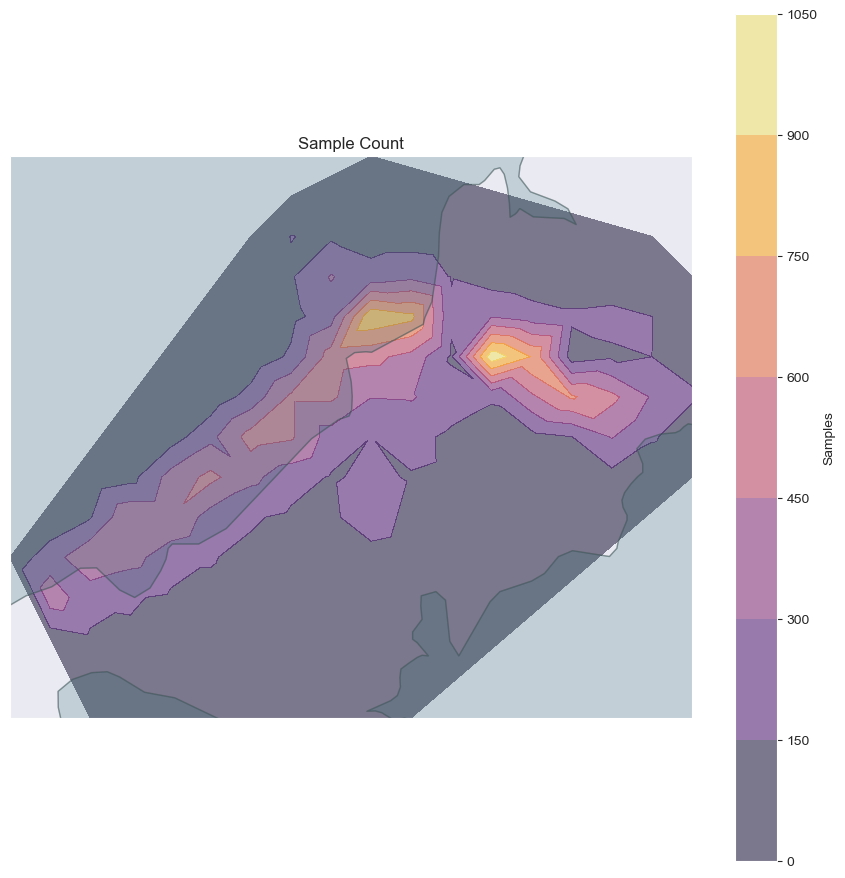

In [48]:
fig, ax = plt.subplots(
    1, 1, figsize=(11, 11), subplot_kw=dict(projection=Projection('epsg:3857')),
)

ax.add_feature(countries())
ax.add_feature(lakes())
ax.add_feature(ocean())

flow = ax.tricontourf(
    tfc_gdf[tfc_gdf['flight_id_nunique'] > 30]['x'],
    tfc_gdf[tfc_gdf['flight_id_nunique'] > 30]['y'],
    tfc_gdf[tfc_gdf['flight_id_nunique'] > 30]['flight_id_nunique'],
    alpha=0.5,
    cmap='inferno')

# aps = ax.scatter(airprox_gdf['x'], airprox_gdf['y'], c='r', marker='x')

ax.set_title('Sample Count')
cb = fig.colorbar(flow)
cb.set_label('Samples')
# ax.legend([aps], ['Airprox'])

Plot a correlation matrix between all variables using the Pearson Correlation Coefficient

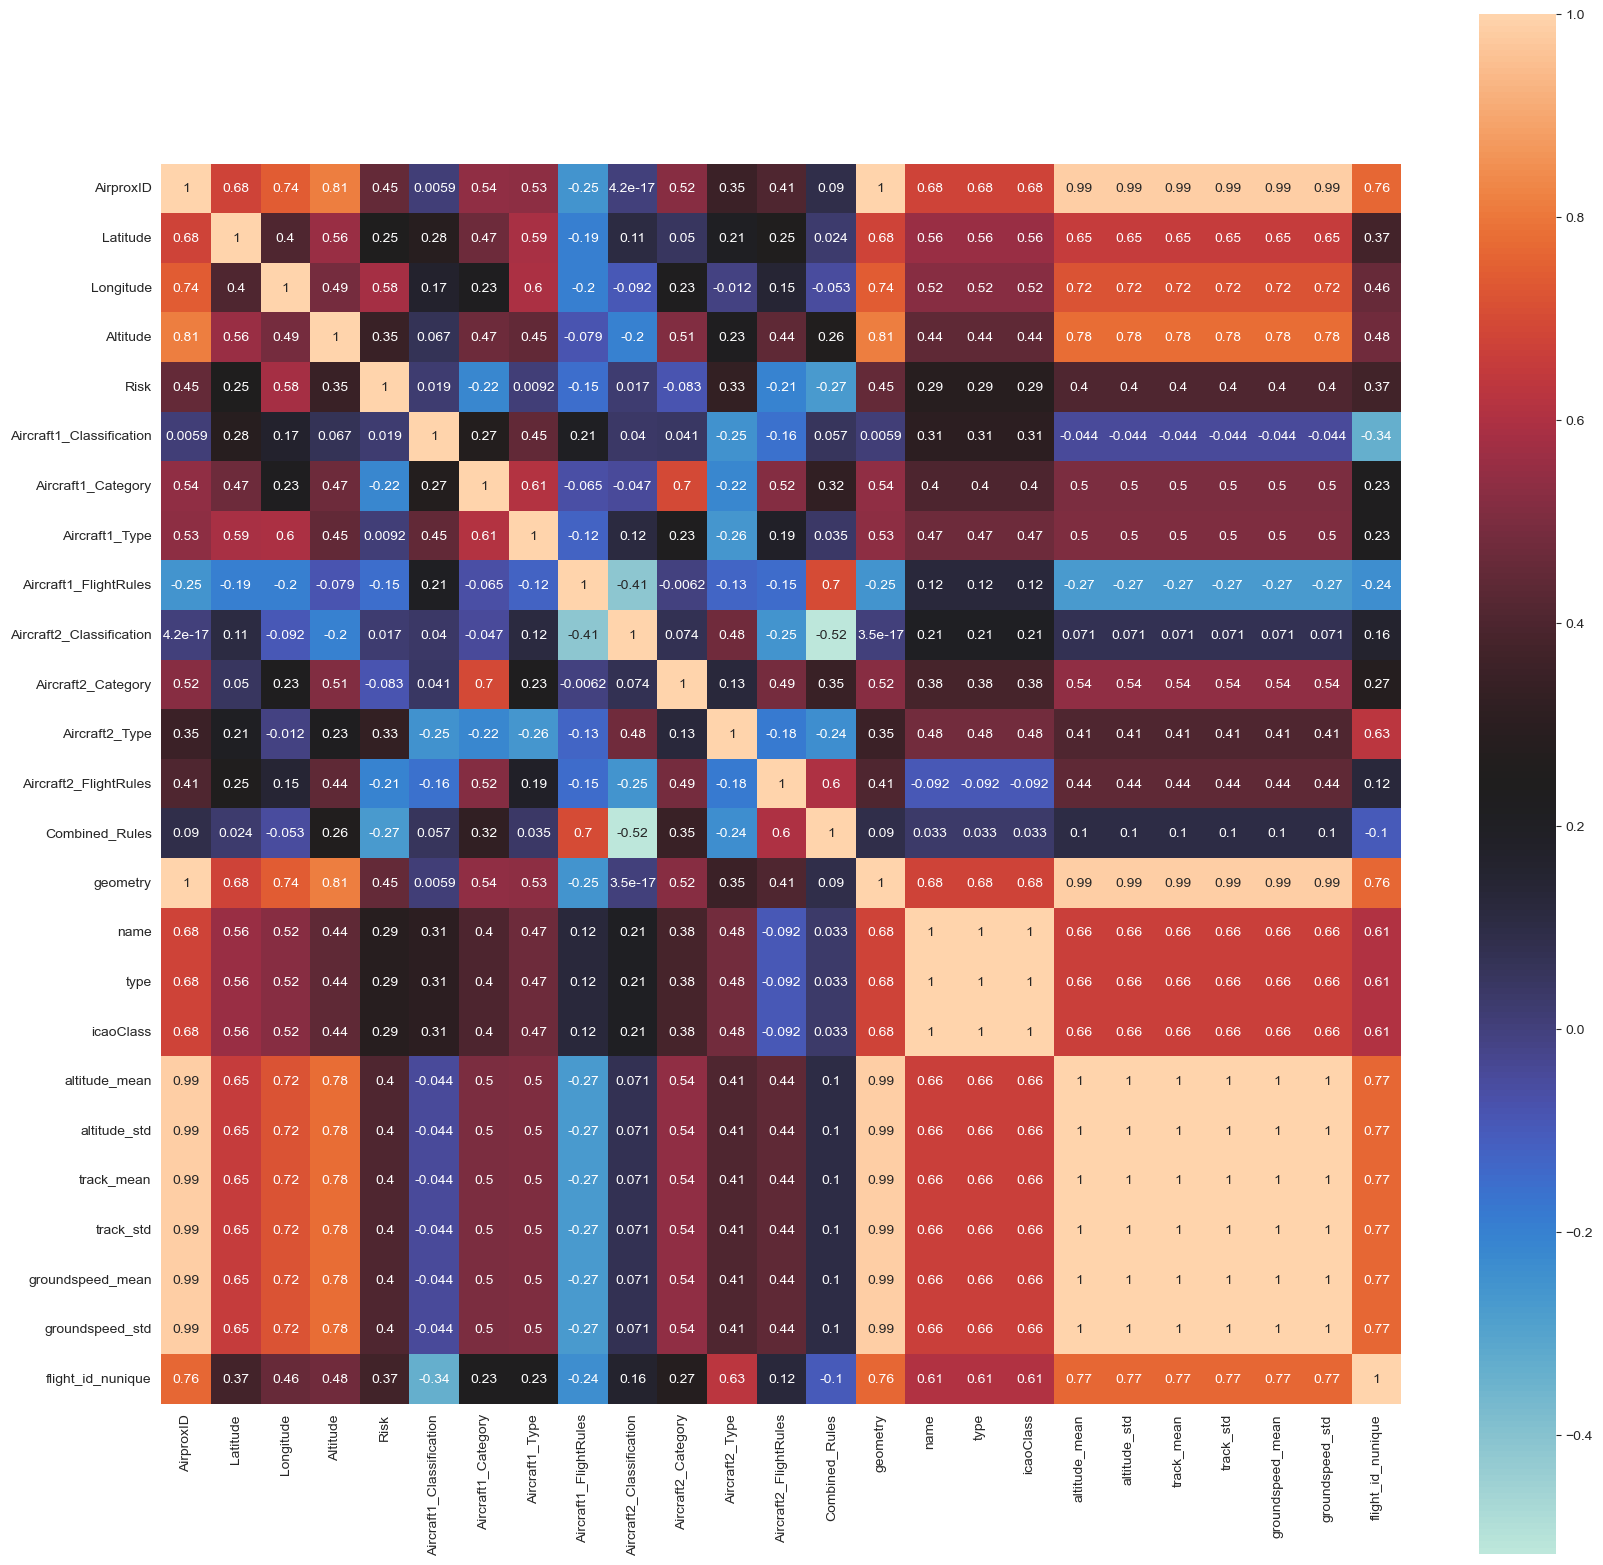

In [49]:
# corr = airproxes_with_tfc.corr(method='spearman')
corr = airproxes_with_tfc.apply(lambda x: pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr, square=True, cmap=sns.color_palette('icefire', as_cmap=True), annot=True, ax=ax)
plt.savefig('corr.svg')

Compute vectors for the quiver plot

In [50]:
tfc_mgdf['track_scale'] = 1 - (tfc_mgdf['track_std'] / tfc_mgdf['track_std'].max())
tfc_mgdf['track_u'] = np.cos(np.radians(tfc_mgdf['track_mean'])) * tfc_mgdf['track_scale']
tfc_mgdf['track_v'] = np.sin(np.radians(tfc_mgdf['track_mean'])) * tfc_mgdf['track_scale']
tfc_mgdf.head()

,x,y,altitude_mean,altitude_std,track_mean,track_std,groundspeed_mean,groundspeed_std,flight_id_nunique,track_scale,track_u,track_v
0,-624000.0,6486000.0,2524.0,1221.827691,194.125,88.615884,130.875,26.369813,47,0.324261,-0.314444,-0.079324
1,-618000.0,6474000.0,2574.0,903.288369,141.125,90.873882,134.000,43.585051,75,0.307043,-0.238978,0.192801
2,-618000.0,6480000.0,2666.0,1036.673502,200.000,77.101737,135.000,26.402432,384,0.412062,-0.387314,-0.140741
3,-618000.0,6486000.0,2548.0,1203.780450,195.375,77.314834,137.875,19.681153,230,0.410437,-0.395807,-0.108922
4,-618000.0,6492000.0,3048.0,931.113359,145.375,96.642526,146.750,31.620701,37,0.263054,-0.216429,0.149509


Plot the mean traffic flow direction for cells with sufficient samples. The scale of the vectors is inversely proportional to the standard deviation of the distribution of directions for that cell. In practice, this means the longer the arrow the more unidirectional and organised the traffic flow is.

Vector colouring is based on direction of the vector and is only to provide more visual difference.

Airprox locations are superimposed for information only.

Both a quiver and contour plot are made to based on the same data

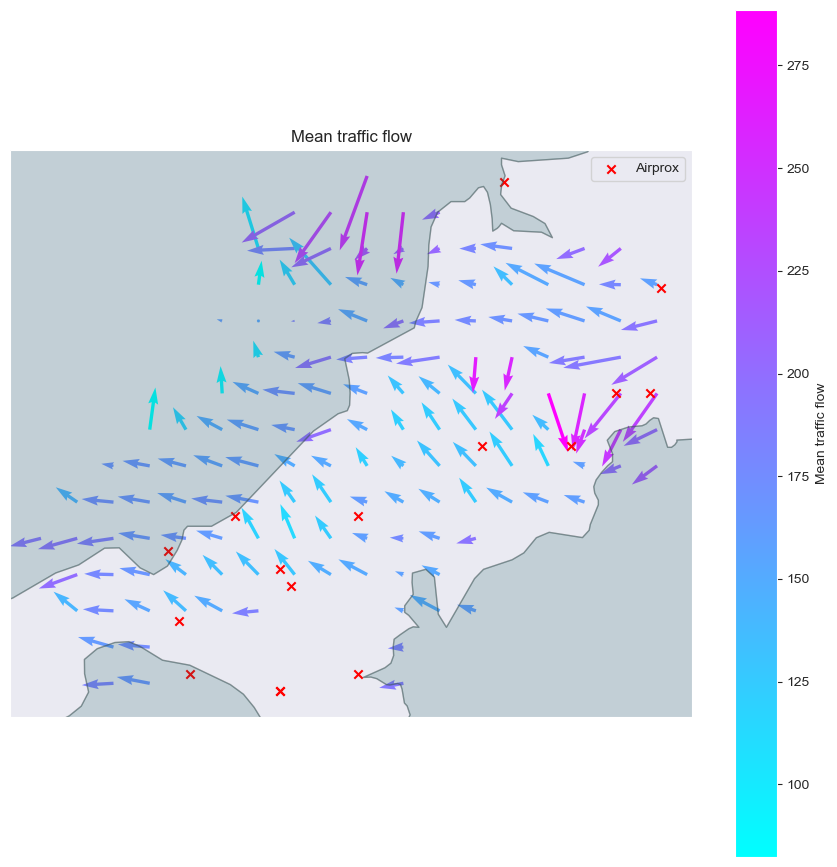

In [51]:
fig, ax = plt.subplots(
    1, 1, figsize=(11, 11), subplot_kw=dict(projection=Projection('epsg:3857')),
)

ax.add_feature(countries())
ax.add_feature(lakes())
ax.add_feature(ocean())

flow = ax.quiver(tfc_mgdf['x'],
                 tfc_mgdf['y'],
                 tfc_mgdf['track_u'],
                 tfc_mgdf['track_v'],
                 tfc_mgdf['track_mean'],
                 scale_units=None,
                 cmap='cool')

aps = ax.scatter(airprox_gdf['x'], airprox_gdf['y'], c='r', marker='x')

ax.set_title('Mean traffic flow')
cb = fig.colorbar(flow)
cb.set_label('Mean traffic flow')
ax.legend([aps], ['Airprox'])

# airports['EGHQ'].point.plot(ax)
# airports['EGHE'].point.plot(ax)
# airports['EGHC'].point.plot(ax)

/home/aliaksei/anaconda3/envs/sandbox/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/aliaksei/anaconda3/envs/sandbox/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


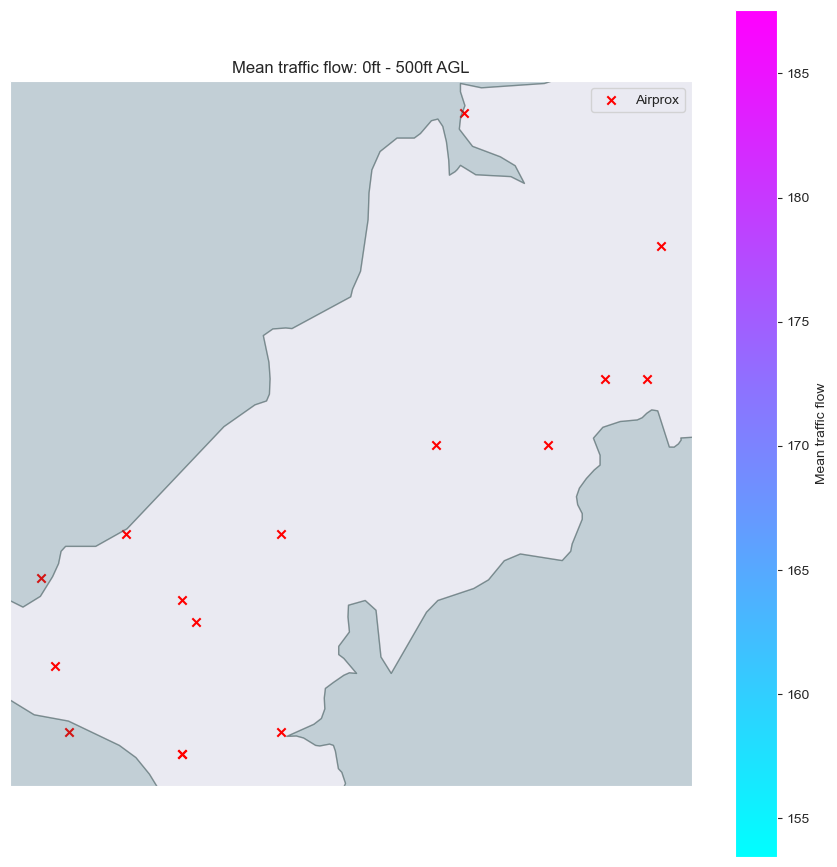

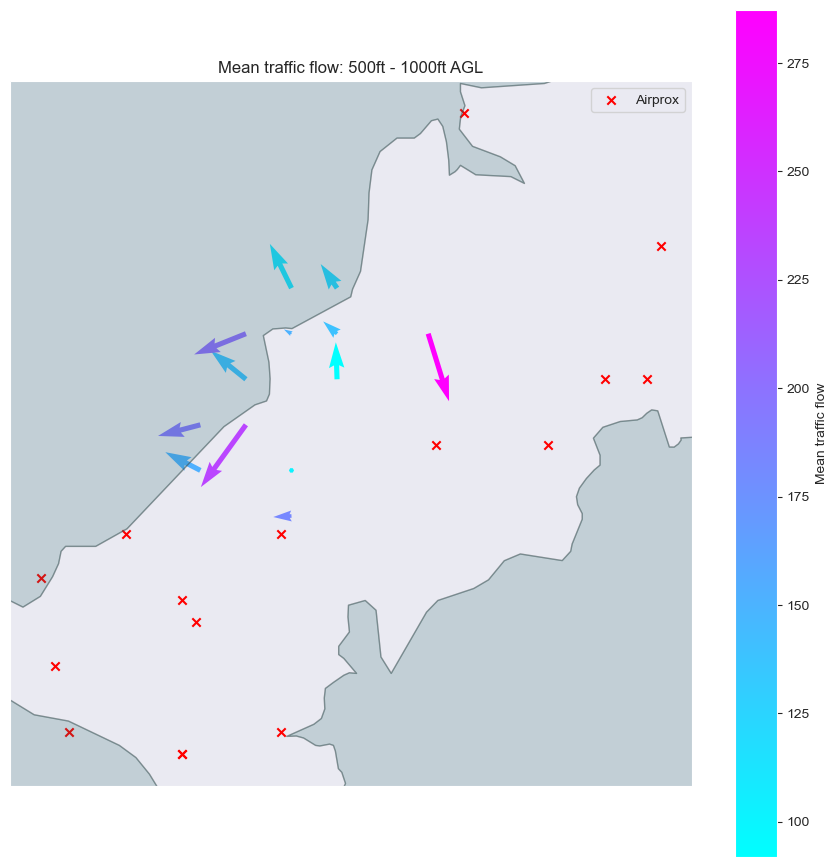

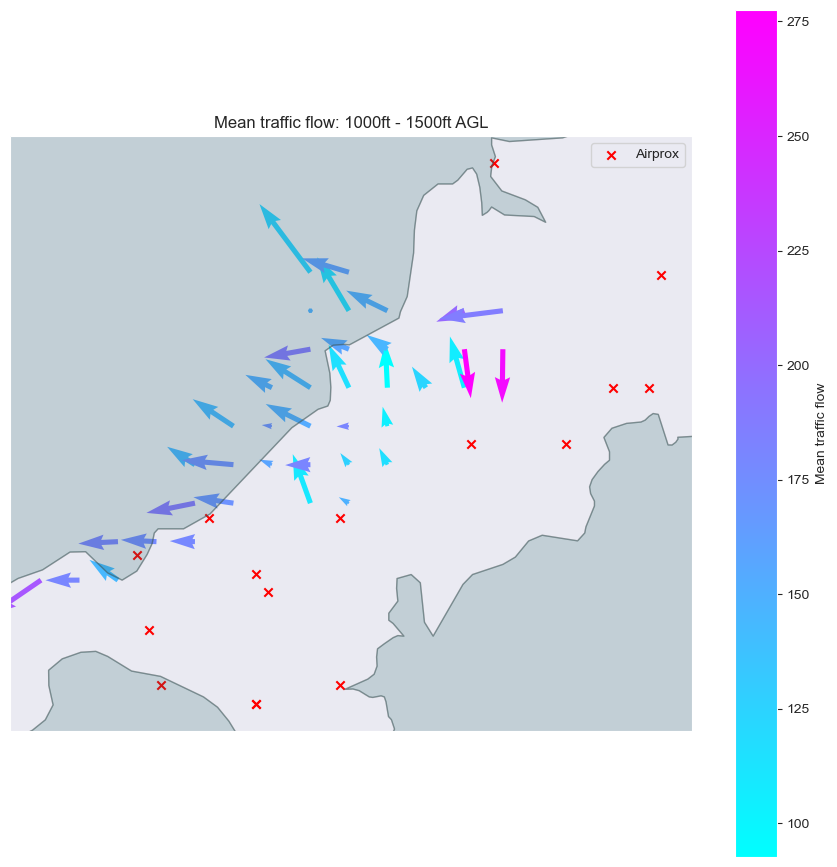

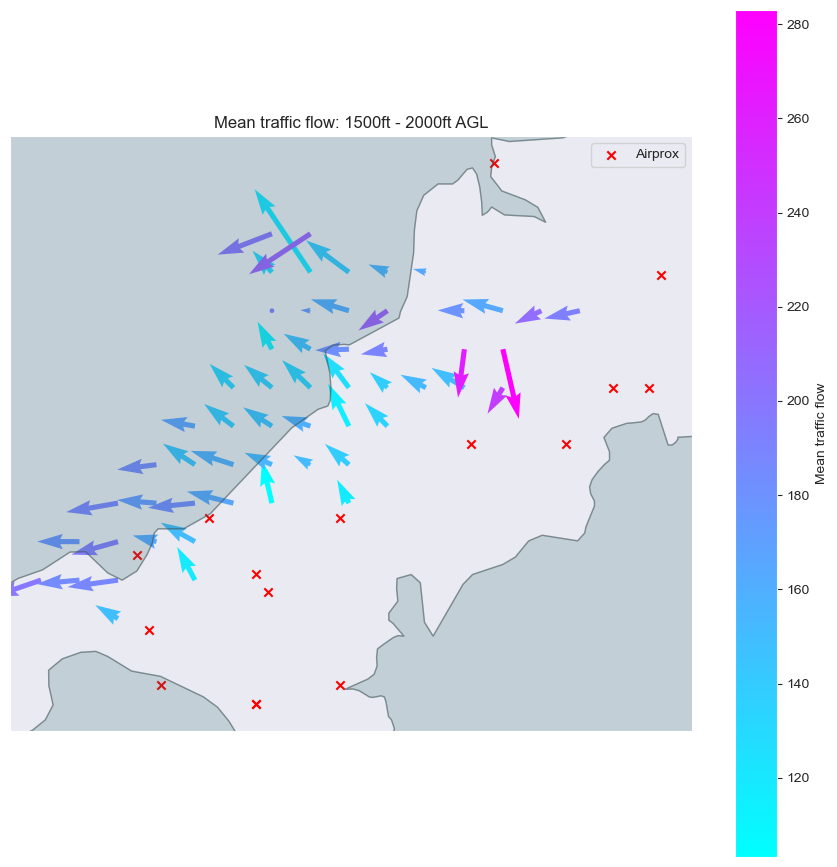

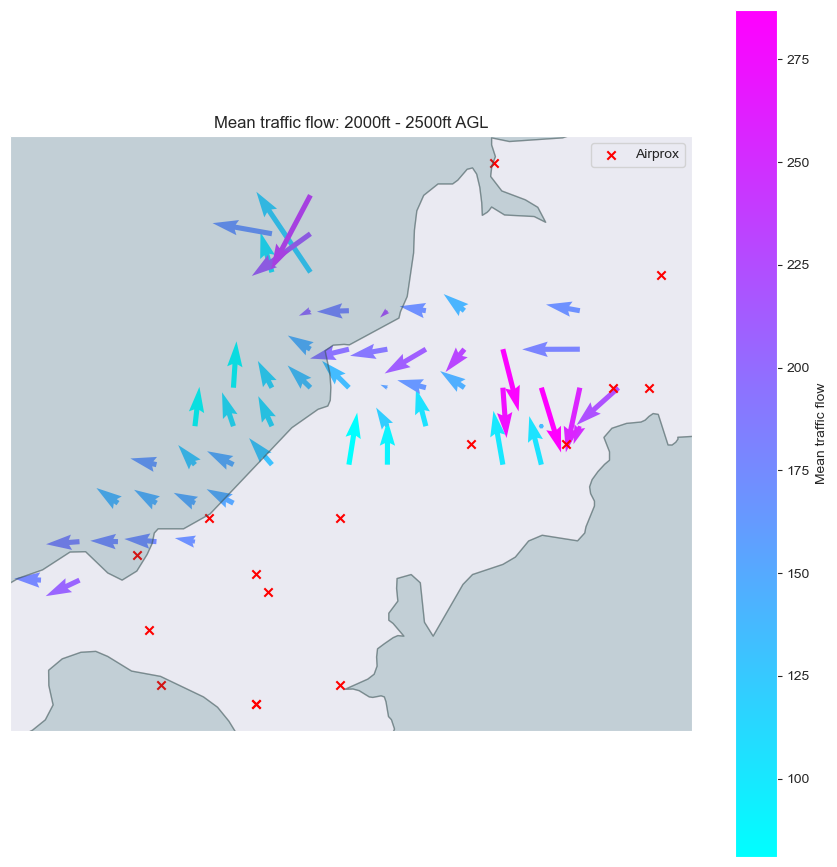

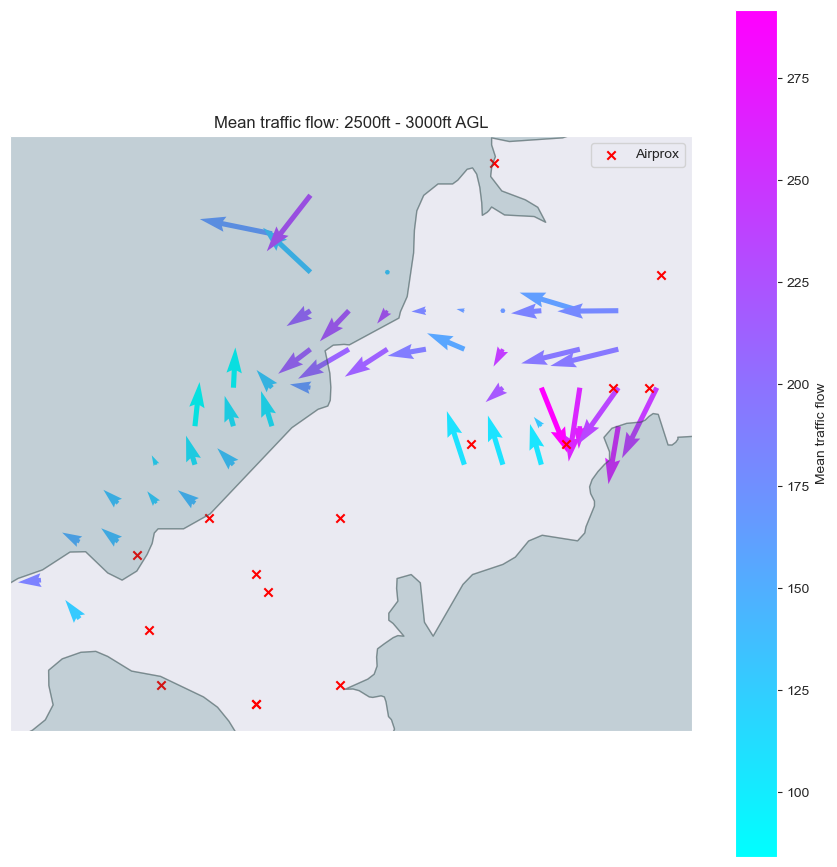

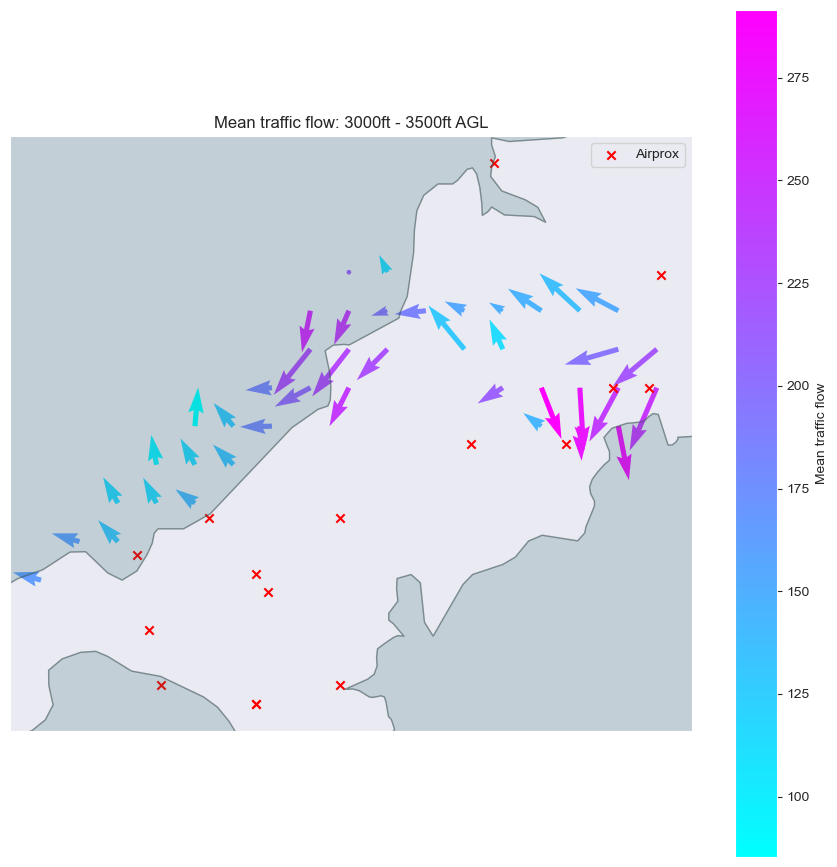

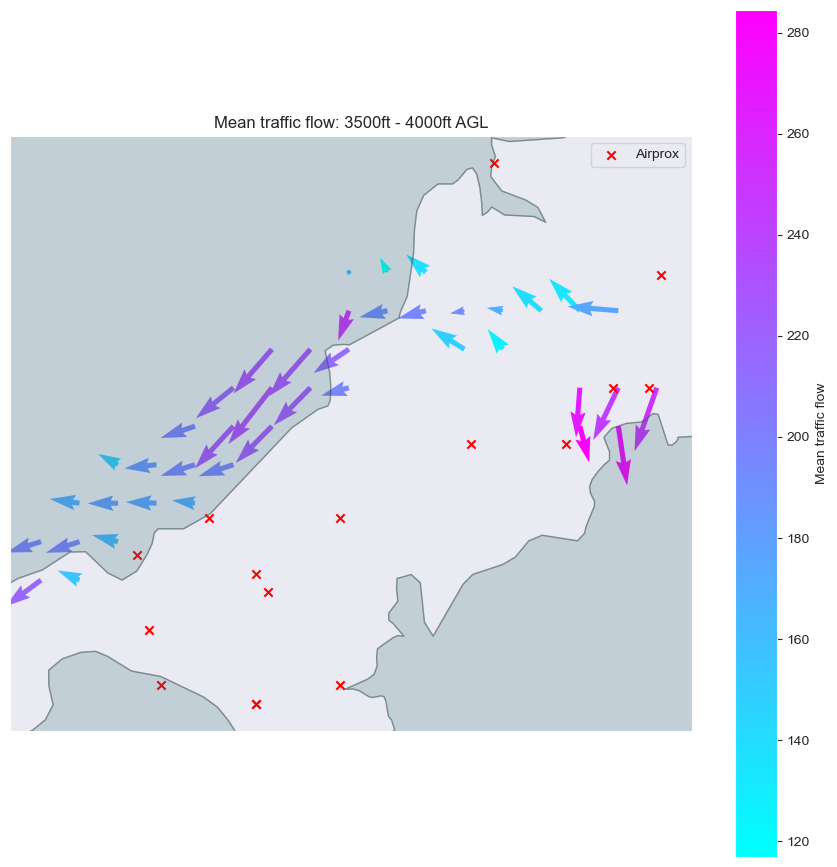

In [62]:
alt_tfc_magg = []
alt_bins = range(0,int(unc_asp_tfc_gdf.altitude.max()+1), 500)
for floor, ceil in zip(alt_bins, alt_bins[1:]):
    tfc_alt_gdf = tfc_unc_xy_gdf.data[(tfc_unc_xy_gdf.data['altitude'] >= floor) & (tfc_unc_xy_gdf.data['altitude'] < ceil)]
    tfc_alt_agg = tfc_alt_gdf.assign(
        x=lambda elt: (elt.x // res) * res,
        y=lambda elt: (elt.y // res) * res,
    ).groupby(["x", "y"]).agg(altitude_mean=pd.NamedAgg('altitude', np.nanmean),
                              altitude_std=pd.NamedAgg('altitude', np.std), track_mean=pd.NamedAgg('track', np.nanmean),
                              track_std=pd.NamedAgg('track', np.std),
                              groundspeed_mean=pd.NamedAgg('groundspeed', np.nanmean),
                              groundspeed_std=pd.NamedAgg('groundspeed', np.std),
                              flight_id_nunique=('flight_id', 'nunique'))
    tfc_alt_mgdf = tfc_alt_agg[tfc_alt_agg['flight_id_nunique'] > 30].reset_index()
    alt_tfc_magg.append(tfc_alt_mgdf)
    
    tfc_alt_mgdf['track_scale'] = 1 - (tfc_alt_mgdf['track_std'] / tfc_alt_mgdf['track_std'].max())
    tfc_alt_mgdf['track_u'] = np.cos(np.radians(tfc_alt_mgdf['track_mean'])) * tfc_alt_mgdf['track_scale']
    tfc_alt_mgdf['track_v'] = np.sin(np.radians(tfc_alt_mgdf['track_mean'])) * tfc_alt_mgdf['track_scale']

    fig, ax = plt.subplots(
        1, 1, figsize=(11, 11), subplot_kw=dict(projection=Projection('epsg:3857')),
    )

    ax.add_feature(countries())
    ax.add_feature(lakes())
    ax.add_feature(ocean())

    flow = ax.quiver(tfc_alt_mgdf['x'],
                     tfc_alt_mgdf['y'],
                     tfc_alt_mgdf['track_u'],
                     tfc_alt_mgdf['track_v'],
                     tfc_alt_mgdf['track_mean'],
                     scale_units=None,
                     cmap='cool')

    aps = ax.scatter(airprox_gdf['x'], airprox_gdf['y'], c='r', marker='x')

    ax.set_title(f'Mean traffic flow: {floor}ft - {ceil}ft AGL')
    cb = fig.colorbar(flow)
    cb.set_label('Mean traffic flow')
    ax.legend([aps], ['Airprox'])


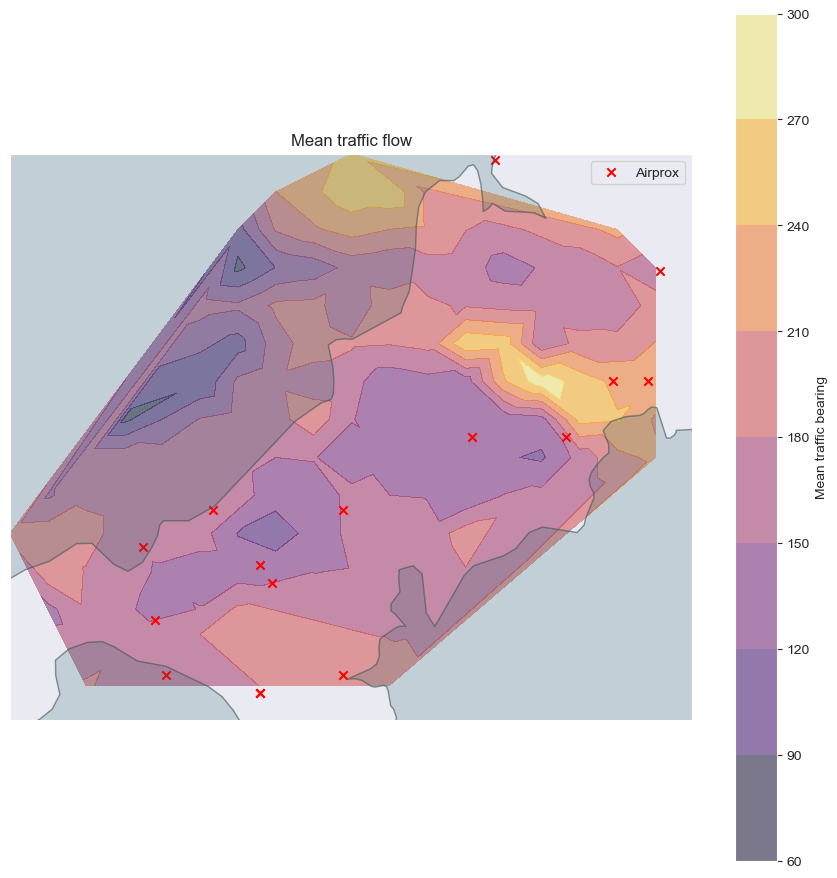

In [59]:
from cartopy.crs import Projection
from traffic.drawing import countries, lakes, ocean
from traffic.data import airports

fig, ax = plt.subplots(
    1, 1, figsize=(11, 11), subplot_kw=dict(projection=Projection('epsg:3857')),
)

ax.add_feature(countries())
ax.add_feature(lakes())
ax.add_feature(ocean())

flow = ax.tricontourf(tfc_mgdf['x'],
                      tfc_mgdf['y'],
                      # tfc_gdf['track_u'],
                      # tfc_gdf['track_v'],
                      tfc_mgdf['track_mean'],
                      alpha=0.5,
                      cmap='inferno')

aps = ax.scatter(airprox_gdf['x'], airprox_gdf['y'], c='r', marker='x')

ax.set_title('Mean traffic flow')
cb = fig.colorbar(flow)
cb.set_label('Mean traffic bearing')
ax.legend([aps], ['Airprox'])

# airports['EGHQ'].point.plot(ax)
# airports['EGHE'].point.plot(ax)
# airports['EGHC'].point.plot(ax)

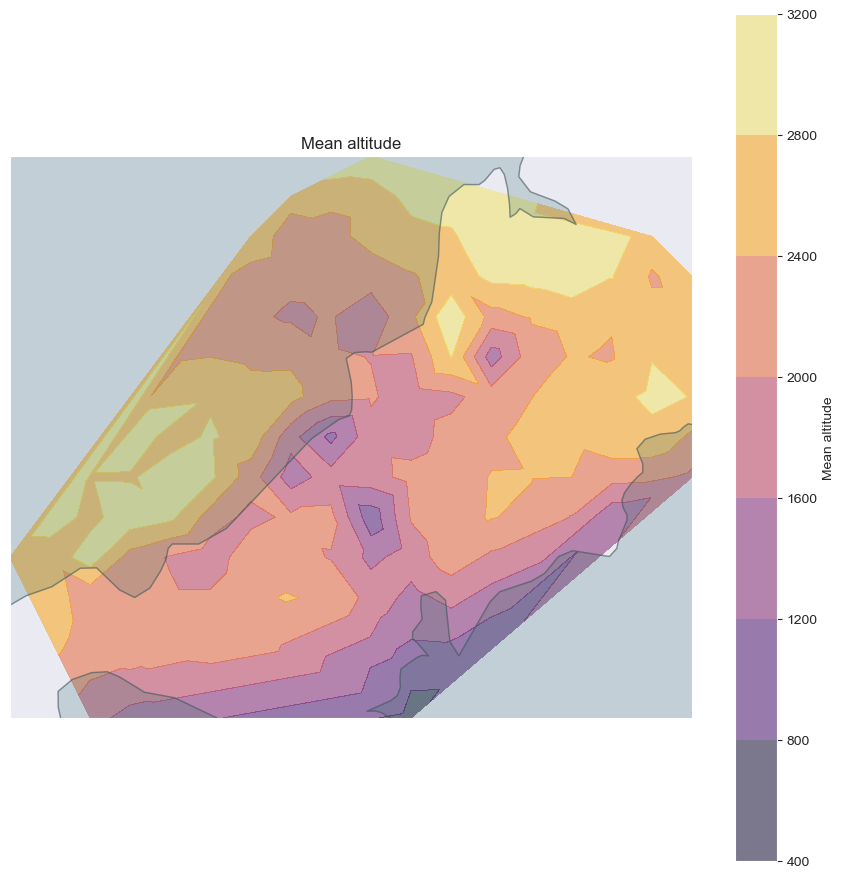

In [53]:
fig, ax = plt.subplots(
    1, 1, figsize=(11, 11), subplot_kw=dict(projection=Projection('epsg:3857')),
)

ax.add_feature(countries())
ax.add_feature(lakes())
ax.add_feature(ocean())

flow = ax.tricontourf(
    tfc_mgdf['x'],
    tfc_mgdf['y'],
    tfc_mgdf['altitude_mean'],
    alpha=0.5,
    cmap='inferno')

# aps = ax.scatter(airprox_gdf['x'], airprox_gdf['y'], c='r', marker='x')

ax.set_title('Mean altitude')
cb = fig.colorbar(flow)
cb.set_label('Mean altitude')
# ax.legend([aps], ['Airprox'])

# Aggregate Stats

In [69]:
ceiling_alt = unc_asp_tfc_gdf.altitude.max() / 3.281
cell_vol = res * res * ceiling_alt
# Get traffic density in each uncontrolled cell
cell_traffic_densities = np.array(tfc_magg['flight_id_nunique']) / ( cell_vol)
print(f'Mean Traffic Density in uncontrolled airspace for data area: {cell_traffic_densities.mean()} aircraft/m^3')
print(f'Equivalent to an aircraft per {np.sqrt((1/cell_traffic_densities.mean())/152.4)}m x 500ft cube')

Mean Traffic Density in uncontrolled airspace for data area: 3.986873712288448e-09 aircraft/m^3
Equivalent to an aircraft per 1282.8954855835102m x 500ft cube


In [55]:
import shapely.geometry as sg

print('World space stats (uncontrolled volumes):')
xy_points = gpd.points_from_xy(tfc_unc_xy_gdf.data['x'], tfc_unc_xy_gdf.data['y'], tfc_unc_xy_gdf.data['altitude'])
convex_hull = sg.MultiPoint(xy_points).convex_hull
min_rot_rect = convex_hull.minimum_rotated_rectangle
print(f"Total area: {min_rot_rect.area} m^2")
print(f"Total volume: {min_rot_rect.area * ceiling_alt} m^3")
coords = [np.array(c) for c in min_rot_rect.exterior.coords[:-1]]
coord_dists = np.unique(cdist(coords, coords).round(decimals=3))
coord_dists = coord_dists[coord_dists > 0]
print(f'Total x,y,z dimensions are {coord_dists[0]}m, {coord_dists[1]}m, {ceiling_alt}m with xy diagonal {coord_dists[2]}m')

World space stats (uncontrolled volumes):
Total area: 34316832283.439693 m^2
Total volume: 31377780204303.28 m^3
Total x,y,z dimensions are 179871.055m, 190785.74m, 914.3553794574824m with xy diagonal 262207.542m


## Testing hypotheses
All tests are done to 5% significance unless otherwise specified.

In [89]:
from scipy import stats as ss

sig_lvl = 0.05

### Track correlation
First, the correlation of direction variance with airprox location is tested. The mean standard deviation for directions in the entire area is found and compared to that of just where airproxes occurred:

In [90]:
print('Overall mean of stddev: ', non_airprox_tfc['track_std'].mean(), ' for ', len(non_airprox_tfc['track_std']),
      ' samples')
print('Airprox location mean of stddev: ', airproxes_with_tfc['track_std'].mean(), 'for ',
      len(airproxes_with_tfc['track_std']), ' samples')

Overall mean of stddev:  90.62413543410744  for  137  samples
Airprox location mean of stddev:  88.66543962695775 for  16  samples


In [91]:
F, p = ss.bartlett(non_airprox_tfc['track_std'], airproxes_with_tfc['track_std'])
print(f'Bartlett equal variance test gives score of {F} at a p-significance of {p}')
if p <= sig_lvl:
    print(f'The hypothesis is accepted (F={F}, p={p})')
else:
    print('Null hypothesis is accepted.')

Bartlett equal variance test gives score of 0.32156393744218986 at a p-significance of 0.5706692882690401
Null hypothesis is accepted.


### Density Correlation

The count of unique flights within a cell is used as a measure of traffic density.

Otherwise the same procedure as above

In [92]:
print('Overall mean: ', non_airprox_tfc['flight_id_nunique'].mean(), ' for ', len(non_airprox_tfc['flight_id_nunique']),
      ' samples')
print('Airprox location mean: ', airproxes_with_tfc['flight_id_nunique'].mean(), 'for ',
      len(airproxes_with_tfc['flight_id_nunique']), ' samples')

Overall mean:  179.2189781021898  for  137  samples
Airprox location mean:  124.0625 for  16  samples


In [93]:
F, p = ss.f_oneway(non_airprox_tfc['flight_id_nunique'], airproxes_with_tfc['flight_id_nunique'])
print(f'One-Way ANOVA test gives F-score of {F} at a p-significance of {p}')
if p <= sig_lvl:
    print(f'The hypothesis is accepted (F={F}, p={p})')
else:
    print('Null hypothesis is accepted.')

One-Way ANOVA test gives F-score of 1.4844277015737615 at a p-significance of 0.224983231354477
Null hypothesis is accepted.


### Speed correlation

First the difference in the overall traffic flow speed is compared between airprox and non-airprox traffic

In [94]:
print('Overall mean: ', np.array(non_airprox_tfc['groundspeed_mean']).mean(), ' for ',
      len(non_airprox_tfc['groundspeed_mean']),
      ' samples')
print('Airprox location mean: ', np.array(airproxes_with_tfc['groundspeed_mean']).mean(), 'for ',
      len(airproxes_with_tfc['groundspeed_mean']), ' samples')

Overall mean:  136.9  for  137  samples
Airprox location mean:  126.9 for  16  samples


In [95]:
F, p = ss.f_oneway(non_airprox_tfc['groundspeed_mean'], airproxes_with_tfc['groundspeed_mean'])
print(f'One-Way ANOVA test gives F-score of {F} at a p-significance of {p}')
if p <= sig_lvl:
    print(f'The hypothesis is accepted (F={F}, p={p})')
else:
    print('Null hypothesis is accepted.')

One-Way ANOVA test gives F-score of 2.0247388537652915 at a p-significance of 0.15681822524529967
Null hypothesis is accepted.


Now the difference in *spread* of traffic flow speeds is compared between airprox and non-airprox traffic

In [96]:
print('Overall mean of stddev: ', np.array(non_airprox_tfc['groundspeed_std']).mean(), ' for ',
      len(non_airprox_tfc['groundspeed_std']),
      ' samples')
print('Airprox location mean of stddev: ', np.array(airproxes_with_tfc['groundspeed_std']).mean(), 'for ',
      len(airproxes_with_tfc['groundspeed_std']), ' samples')

Overall mean of stddev:  37.533975855413445  for  137  samples
Airprox location mean of stddev:  41.439882197447524 for  16  samples


In [97]:
F, p = ss.bartlett(non_airprox_tfc['groundspeed_std'], airproxes_with_tfc['groundspeed_std'])
print(f'Bartlett equal variance test gives score of {F} at a p-significance of {p}')
if p <= sig_lvl:
    print(f'The hypothesis is accepted (F={F}, p={p})')
else:
    print('Null hypothesis is accepted.')

Bartlett equal variance test gives score of 1.2311940900286606 at a p-significance of 0.2671749416304806
Null hypothesis is accepted.


# Adherence to Semicircular Rule
Check to see if traffic tends to follow the [Semicircular rule](https://en.wikipedia.org/wiki/Flight_level#Semicircular/hemispheric_rule)

In [1]:
tfc_magg['track_mean']

NameError: name 'tfc_magg' is not defined

In [ ]:
tfc_alt_agg